In [3]:
import pyodbc
import pandas as pd

# Connection string
conn_string = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=LAPTOP-KMUCOE6J\\MSSQLSERVER01;"
    "DATABASE=db_churn;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

try:
    with pyodbc.connect(conn_string) as cnxn:
        # Query 1: Get data from Vw_ChurnData
        sql_query_churn = """
            SELECT * FROM [dbo].[Vw_ChurnData];
        """
        churn_df = pd.read_sql(sql_query_churn, cnxn)

        # Query 2: Get data from Vw_JoinData
        sql_query_join = """
            SELECT * FROM [dbo].[Vw_JoinData];
        """
        join_df = pd.read_sql(sql_query_join, cnxn)

        print("Data loaded successfully!")

        # Use ExcelWriter to save both DataFrames to the same Excel file
        with pd.ExcelWriter('prediction_data.xlsx') as writer:
            churn_df.to_excel(writer, sheet_name='vw_ChurnData', index=False)
            join_df.to_excel(writer, sheet_name='vw_JoinData', index=False)

        print("Excel file created with two sheets: 'vw_ChurnData' and 'vw_JoinData'.")

except Exception as e:
    print(f"Error: {e}")

C:\Users\Asus\AppData\Local\Temp\ipykernel_11880\3186937316.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  churn_df = pd.read_sql(sql_query_churn, cnxn)
C:\Users\Asus\AppData\Local\Temp\ipykernel_11880\3186937316.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  join_df = pd.read_sql(sql_query_join, cnxn)


Data loaded successfully!
Excel file created with two sheets: 'vw_ChurnData' and 'vw_JoinData'.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

file_path = 'prediction_data.xlsx'
sheet_name = 'vw_ChurnData'
data = pd.read_excel(file_path, sheet_name=sheet_name)
print(data.head())

  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   12052-PUN  Female   33      No          Punjab                   11   
1   12069-UTT  Female   30     Yes   Uttar Pradesh                   10   
2   12079-MAH  Female   73     Yes     Maharashtra                    2   
3   12112-MAD  Female   27      No  Madhya Pradesh                   14   
4   12118-TAM  Female   23      No      Tamil Nadu                    7   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                31        NaN           Yes            Yes  ...   
1                14     Deal 4           Yes             No  ...   
2                 4        NaN           Yes             No  ...   
3                 4     Deal 5           Yes             No  ...   
4                 3     Deal 2           Yes            Yes  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal     115.000000   7396.149902           0.0   
1  Bank Wi

In [5]:
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)
# List of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

# Encode categorical variables except the target variable
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])
    
# Manually encode the target variable 'Customer_Status'
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# Split data into features and target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Confusion Matrix:
[[789  51]
 [140 222]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       840
           1       0.81      0.61      0.70       362

    accuracy                           0.84      1202
   macro avg       0.83      0.78      0.80      1202
weighted avg       0.84      0.84      0.83      1202



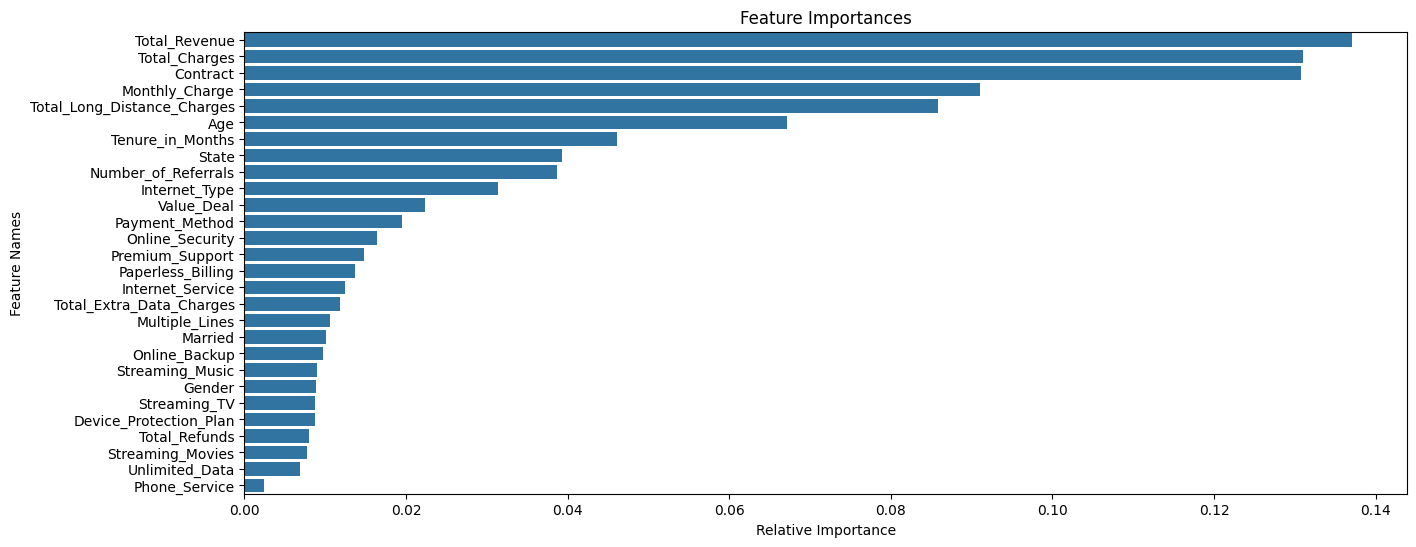

In [7]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

In [15]:
file_path = file_path = 'prediction_data.xlsx'
sheet_name = 'vw_JoinData'
new_data = pd.read_excel(file_path, sheet_name=sheet_name)
print(new_data.head())

# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()

# Retain the Customer_ID column
customer_ids = new_data['Customer_ID']
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])

new_predictions = rf_model.predict(new_data)

original_data['Customer_Status_Predicted'] = new_predictions

original_data = original_data[original_data['Customer_Status_Predicted'] == 1]
print(f"The number of predicted churners is: {len(original_data)}")

original_data.to_csv(r"C:\Users\Asus\Downloads\Predictions.csv", index=False)

  Customer_ID  Gender  Age Married          State  Number_of_Referrals  \
0   12056-WES    Male   27      No    West Bengal                    2   
1   12136-RAJ  Female   25     Yes      Rajasthan                    2   
2   12257-ASS  Female   39      No          Assam                    9   
3   15803-UTT  Female   34      No  Uttar Pradesh                    6   
4   17597-HAR  Female   33     Yes        Haryana                    2   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                20        NaN           Yes             No  ...   
1                35        NaN           Yes             No  ...   
2                 1        NaN           Yes             No  ...   
3                31        NaN           Yes             No  ...   
4                 6     Deal 5            No             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      90.400002    268.450012           0.0   
1  Bank Withdraw